# BLE distance measurement results

The test have been made with two NRF54L15-DK device. Distance measurements were taken at every meter from 0m to 1m. The distance was controlled using a measuring tape. The tests have been performed in a indoor and outdoor environement for both RSSI and Channel Sounding measurement. The results store in 4 diffrent files.

- _cs-indoor-meas.csv_
- _cs-outdoor-meas.csv_
- _rssi-indoor-meas.csv_
- _rssi-outdoor-meas.csv_

In [46]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [47]:
# read CSV files
cs_indoor = pd.read_csv('accuracy/cs-indoor-meas.csv')
cs_outdoor = pd.read_csv('accuracy/cs-outdoor-meas.csv')
rssi_indoor = pd.read_csv('accuracy/rssi-indoor-meas.csv')
rssi_outdoor = pd.read_csv('accuracy/rssi-outdoor-meas.csv')
rssi_range = pd.read_csv('range/rssi-range-meas.csv')
cs_range = pd.read_csv('range/cs-range-meas.csv')

# quick summary
for name, df in [
    ('rssi_indoor', rssi_indoor),
    ('rssi_outdoor', rssi_outdoor),
]:
    print(f"{name}: shape={df.shape}")
    display(df.head())


rssi_indoor: shape=(231, 3)


,meas num,rssi [dBm],distance [m]
0,0,-25,0.37
1,1,-27,0.42
2,2,-27,0.42
3,3,-25,0.37
4,4,-26,0.39


rssi_outdoor: shape=(231, 3)


,meas num,rssi [dBm],distance [m]
0,0,-18,0.07
1,1,-19,0.08
2,2,-19,0.08
3,3,-18,0.07
4,4,-18,0.07


In [48]:
# Mean calculation function
def calculate_mean_distance(distance_data, column_name, nbr_samples=21):
        
    distance_values = distance_data[column_name].values
    mean_distance   = []

    for i in range(11): 
        start_idx = i * nbr_samples
        end_idx = (i + 1) * nbr_samples

        # Check if we have enough data
        if end_idx <= len(distance_values):
            mean_val = np.mean(distance_values[start_idx:end_idx])
            floored_mean = np.floor(mean_val * 100) / 100
            mean_distance.append(floored_mean)
        
    return mean_distance


In [49]:
# Standard deviation calculation function
def calculate_std_distance(distance_data, column_name, nbr_samples=21):
        
    distance_values = distance_data[column_name].values
    std_distance   = []

    for i in range(11):
        start_idx = i * nbr_samples
        end_idx = (i + 1) * nbr_samples

        # Check if we have enough data
        if end_idx <= len(distance_values):
            std_val = np.std(distance_values[start_idx:end_idx])
            floored_std = np.floor(std_val * 100) / 100
            std_distance.append(floored_std)

    return std_distance

In [50]:
# Distance calculation function
def calculate_distance(tx_power, rssi, n):
    return 10 ** ((tx_power - rssi) / (10 * n))

In [ ]:
# Part loss index optimisation function
def optimize_path_loss_exponent(values):
        ref_dist = list(range(11))

        best_n = None
        min_error = float('inf')
        error = np.array([])

        c = np.linspace(2, 5, 25)

        for c_val in c:
                for rssi in values:
                        dist = calculate_distance(-40, rssi, c_val)
                        error = np.append(error, abs(dist - ref_dist[values.index(rssi)]))
                        
                if np.mean(error) < min_error:
                        min_error = np.mean(error)
                        best_c = c_val

        return best_c, min_error


rssi_indoor_optimised_values = optimize_path_loss_exponent(calculate_mean_distance(rssi_indoor, "rssi [dBm]",nbr_samples=21))

print("Optimized path loss exponent for RSSI Indoor:", rssi_indoor_optimised_values)

rssi_outdoor_optimised_values = optimize_path_loss_exponent(calculate_mean_distance(rssi_outdoor, "rssi [dBm]",nbr_samples=21))

print("Optimized path loss exponent for RSSI Outdoor:", rssi_outdoor_optimised_values)


Optimized path loss exponent for RSSI Indoor: (2.0, 1.9512251005356895)
Optimized path loss exponent for RSSI Outdoor: (2.375, 1.3444917228639164)


In [52]:
def plot_distance_measurements(distance_data, column_name, nbr_samples=21, title="Distance Measurements"):
    """
    Plot reference distance vs measured distance with scatter points and reference line.
    """
    
    # Prepare data for plotting
    ref_distances = []
    measured_distances = []
    
    # Extract the distance column as numpy array
    distance_values = distance_data[column_name].values

    # For each reference distance (0-10m)
    for i in range(11):
        ref_dist = i  # Reference distance in meters
        
        # Get the 21 distance measurements for this reference distance
        start_idx = i * nbr_samples
        end_idx = (i + 1) * nbr_samples

        # Check if we have enough data
        if end_idx <= len(distance_values):
            distance_measurements = distance_values[start_idx:end_idx]
            
            # Store each measurement with its reference distance
            for measured_dist in distance_measurements:
                ref_distances.append(ref_dist)
                measured_distances.append(measured_dist)
    
    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    
    # Plot scatter points for all measurements
    plt.scatter(ref_distances, measured_distances, alpha=0.6, s=50, 
                label='Measurements', color='blue')
    
    # Error bars for standard deviation
    plt.errorbar(range(11), calculate_mean_distance(distance_data, column_name, nbr_samples), 
                 yerr=calculate_std_distance(distance_data, column_name, nbr_samples), 
                 fmt='o', color='orange', ecolor='black',label='Mean + STD', elinewidth=2, capsize=5, zorder=4)
        
    # Plot reference line (1:1 correspondence)
    ref_line = np.linspace(0, 10, 100)
    plt.plot(ref_line, ref_line, 'r-', linewidth=2, label='Reference')
    
        # Set major ticks every 1 unit
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    # Labels and formatting
    plt.xlabel('Reference Distance [m]', fontsize=12)
    plt.ylabel('Measured Distance [m]', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, which='major')
    plt.legend(fontsize=10)
    plt.xlim(-0.5, 10.5)
    plt.ylim(0, 10.5 if max(measured_distances) <= 10.5 else max(measured_distances) + 0.5)


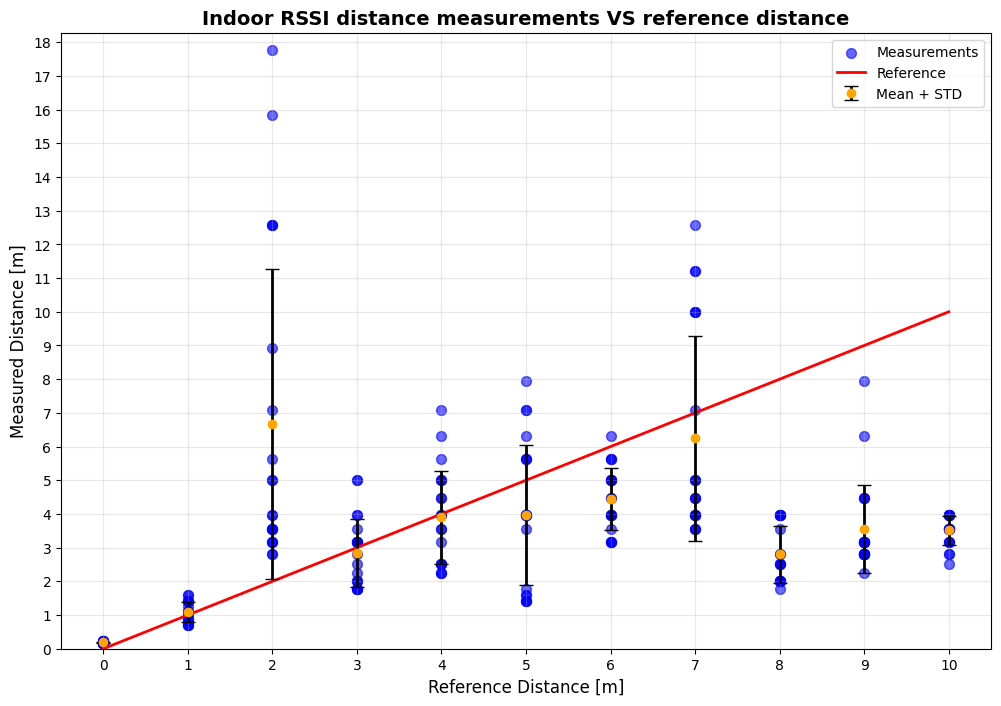

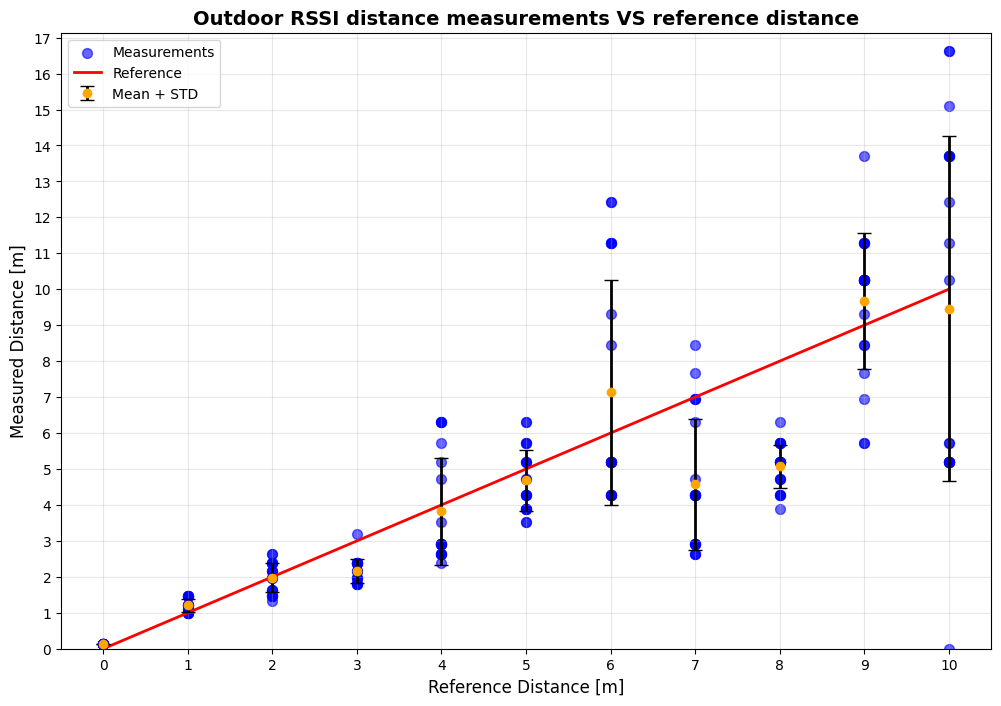

In [53]:

rssi_indoor["opti distance [m]"] = calculate_distance(-40, rssi_indoor["rssi [dBm]"].values, rssi_indoor_optimised_values[0])
rssi_outdoor["opti distance [m]"] = calculate_distance(-40, rssi_outdoor["rssi [dBm]"].values, rssi_outdoor_optimised_values[0])

plot_distance_measurements(rssi_indoor, "opti distance [m]", 21, "Indoor RSSI distance measurements VS reference distance")
plot_distance_measurements(rssi_outdoor, "opti distance [m]", 21, "Outdoor RSSI distance measurements VS reference distance")

In [55]:
rssi_indoor_mean_distance = calculate_mean_distance(rssi_indoor, "distance [m]", 21)
rssi_outdoor_mean_distance = calculate_mean_distance(rssi_outdoor, "distance [m]", 21)
rssi_indoor_mean_distance_optimised = calculate_mean_distance(rssi_indoor, "opti distance [m]", 21)
rssi_outdoor_mean_distance_optimised = calculate_mean_distance(rssi_outdoor, "opti distance [m]", 21)

ref_distances = list(range(11))
rssi_indoor_mean_distance_diff = np.abs(np.array(rssi_indoor_mean_distance) - np.array(ref_distances))
rssi_outdoor_mean_distance_diff = np.abs(np.array(rssi_outdoor_mean_distance) - np.array(ref_distances))
rssi_indoor_mean_distance_diff_optimised = np.abs(np.array(rssi_indoor_mean_distance_optimised) - np.array(ref_distances))
rssi_outdoor_mean_distance_diff_optimised = np.abs(np.array(rssi_outdoor_mean_distance_optimised) - np.array(ref_distances))

rssi_indoor_std = calculate_std_distance(rssi_indoor, "distance [m]", 21)
rssi_outdoor_std = calculate_std_distance(rssi_outdoor, "distance [m]", 21)
rssi_indoor_std_optimised = calculate_std_distance(rssi_indoor, "opti distance [m]", 21)
rssi_outdoor_std_optimised = calculate_std_distance(rssi_outdoor, "opti distance [m]", 21)

rssi_indoor_std_mean = np.mean(rssi_indoor_std)
rssi_outdoor_std_mean = np.mean(rssi_outdoor_std)
rssi_indoor_std_mean_optimised = np.mean(rssi_indoor_std_optimised)
rssi_outdoor_std_mean_optimised = np.mean(rssi_outdoor_std_optimised)

print("Indoor RSSI mean distance:", rssi_indoor_mean_distance)
print("Indoor RSSI mean distance diff:", rssi_indoor_mean_distance_diff)
print("Indoor RSSI std:", rssi_indoor_std)
print("Indoor RSSI std mean:", rssi_indoor_std_mean)
print("\n")

print("Indoor RSSI mean distance optimised:", rssi_indoor_mean_distance_optimised)
print("Indoor RSSI mean distance diff optimised:", rssi_indoor_mean_distance_diff_optimised)
print("Indoor RSSI std optimised:", rssi_indoor_std_optimised)
print("Indoor RSSI std mean optimised:", rssi_indoor_std_mean_optimised)
print("\n")

print("Outdoor RSSI mean distance:", rssi_outdoor_mean_distance)
print("Outdoor RSSI mean distance diff:", rssi_outdoor_mean_distance_diff)
print("Outdoor RSSI std:", rssi_outdoor_std)
print("Outdoor RSSI std mean:", rssi_outdoor_std_mean)
print("\n")

print("Outdoor RSSI mean distance optimised:", rssi_outdoor_mean_distance_optimised)
print("Outdoor RSSI mean distance diff optimised:", rssi_outdoor_mean_distance_diff_optimised)
print("Outdoor RSSI std optimised:", rssi_outdoor_std_optimised)
print("Outdoor RSSI std mean optimised:", rssi_outdoor_std_mean_optimised)
print("\n")

print("Indoor RSSI mean error and standart deviation:", np.mean(rssi_indoor_mean_distance_diff), rssi_indoor_std_mean)
print("Indoor RSSI mean error and standart deviation optimised:", np.mean(rssi_indoor_mean_distance_diff_optimised), rssi_indoor_std_mean_optimised)
print("Outdoor RSSI mean error and standart deviation:", np.mean(rssi_outdoor_mean_distance_diff), rssi_outdoor_std_mean)
print("Outdoor RSSI mean error and standart deviation optimised:", np.mean(rssi_outdoor_mean_distance_diff_optimised), rssi_outdoor_std_mean_optimised)

Indoor RSSI mean distance: [0.38, 1.03, 2.81, 1.78, 2.14, 2.11, 2.33, 2.77, 1.77, 2.03, 2.04]
Indoor RSSI mean distance diff: [0.38 0.03 0.81 1.22 1.86 2.89 3.67 4.23 6.23 6.97 7.96]
Indoor RSSI std: [0.02, 0.16, 1.06, 0.36, 0.43, 0.68, 0.27, 0.74, 0.3, 0.39, 0.14]
Indoor RSSI std mean: 0.4136363636363635


Indoor RSSI mean distance optimised: [0.19, 1.08, 6.68, 2.84, 3.9, 3.96, 4.44, 6.24, 2.8, 3.55, 3.51]
Indoor RSSI mean distance diff optimised: [0.19 0.08 4.68 0.16 0.1  1.04 1.56 0.76 5.2  5.45 6.49]
Indoor RSSI std optimised: [0.02, 0.3, 4.6, 1.0, 1.38, 2.08, 0.91, 3.04, 0.84, 1.31, 0.42]
Indoor RSSI std mean optimised: 1.4454545454545455


Outdoor RSSI mean distance: [0.07, 1.25, 2.26, 2.51, 4.99, 6.28, 10.52, 6.18, 6.88, 14.87, 15.2]
Outdoor RSSI mean distance diff: [0.07 0.25 0.26 0.49 0.99 1.28 4.52 0.82 1.12 5.87 5.2 ]
Outdoor RSSI std: [0.0, 0.22, 0.56, 0.46, 2.31, 1.38, 5.49, 2.94, 0.99, 3.4, 8.03]
Outdoor RSSI std mean: 2.3436363636363637


Outdoor RSSI mean distance optim